In [1]:
!pip install swig
!pip install gymnasium
!pip install box2d
!pip3 install box2d box2d-kengz

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.distributions.categorical import Categorical




In [3]:
DEVICE = 'cpu'
x=1

In [4]:
#policy and value
class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_space_size=153, action_space_size=30):
        super(ActorCriticNetwork, self).__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(19, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        # Policy head
        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size),
            nn.Softmax(dim=-1)  # Softmax layer for discrete action space
        )

        # Value head
        self.value_layers = nn.Linear(64, 1)  # Output a single value

    def forward(self, obs):
        shared_output = self.shared_layers(obs)

        policy_logits = self.policy_layers(shared_output)
        value = self.value_layers(shared_output)

        return policy_logits, value

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

actor_critic = ActorCriticNetwork(obs_space_size=153, action_space_size=30)



In [5]:
class PPOTrainer():
    def __init__(self,
                 actor_critic,
                 ppo_clip_val=0.2,
                 target_kl_div=0.02,
                 max_policy_train_iters=80,
                 value_train_iters=80,
                 policy_lr=1e-2,
                 value_lr=1e-2):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters

        # Initialize optimizers for policy and value networks
        policy_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

        value_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad()

            # Calculate new log probabilities of actions
            new_logits = self.ac.policy(obs)
            new_probs = Categorical(logits=new_logits)
            new_log_probs = new_probs.log_prob(acts)

            # Calculate policy ratio
            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_ratio = policy_ratio.clamp(
                1 - self.ppo_clip_val, 1 + self.ppo_clip_val)

            # Calculate policy loss and perform backpropagation
            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()

            policy_loss.backward()
            self.policy_optim.step()

            # Early stopping based on KL divergence
            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def train_value(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            # Calculate value loss and perform backpropagation
            values = self.ac.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()

    @staticmethod
    def discount_rewards(rewards, gamma=0.98):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = running_add * gamma + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

        
    @staticmethod
    def calculate_gaes(rewards, values, gamma=0.98, lambda_=0.95):
        advantages = np.zeros_like(rewards, dtype=np.float32)
        gae = 0
        next_values = np.append(values[1:], 0)

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + gamma * next_values[t] - values[t]
            gae = delta + gamma * lambda_ * gae
            advantages[t] = gae

        return advantages

    def rollout(model, env, max_steps=1000):
        obs = env.reset()
        ep_reward = 0
        train_data = {'obs': [], 'acts': [], 'rewards': [], 'values': [], 'log_probs': []}

        for step in range(max_steps):
            # Convert the list of numpy arrays to a single numpy array before converting to a tensor
            obs_array = np.array(obs)
            obs_tensor = torch.tensor(obs_array, dtype=torch.float32)

            logits, val = model(obs_tensor)
            act_distribution = Categorical(logits=logits)
            act = act_distribution.sample()
            act_log_prob = act_distribution.log_prob(act)

            next_obs, reward, done, _ = env.step(act.item())
            ep_reward += reward

            train_data['obs'].append(obs)
            train_data['acts'].append(act.item())
            train_data['rewards'].append(reward)
            train_data['values'].append(val.item())
            train_data['log_probs'].append(act_log_prob.item())

            obs = next_obs

            if done:
                break

        # Convert lists to numpy arrays for further processing
        for key in train_data.keys():
            train_data[key] = np.array(train_data[key])

        # Post-process rewards and values
        train_data['values'] = calculate_gaes(train_data['rewards'], train_data['values'])
        train_data['rewards'] = discount_rewards(train_data['rewards'])

        return train_data, ep_reward





In [6]:
import gym
import numpy as np
import random
import os
import pandas as pd
import pickle
import json
from gym import spaces

class SatelliteServiceEnv(gym.Env):
    def __init__(self, path_to='dataset_30/', n_services=50, n_satellites=10, api_cost=0.5, reward_scale=10):
        super(SatelliteServiceEnv, self).__init__()

        self.n_satellites = n_satellites
        self.n_services = n_services
        self.API_COST = api_cost
        self.REWARD_SCALE = reward_scale
        self.path_to = path_to
        self.load_and_merge_data(self.path_to)

        features_per_satellite = 5  # Adjust as needed
        features_per_service = 3  # Adjust as needed

        self.obs_space_size = features_per_satellite * self.n_satellites + features_per_service
        self.observation_space = spaces.Box(low=0, high=200, shape=(self.obs_space_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.n_satellites)

        self.state = None
        self.current_service = 0
        self.prev_api_cost = None
        self.allocated_services = set()

        self.satellite_data = self.generate_satellite_data()
        self.service_data = self.generate_service_data()
        self.api_costs = self.generate_api_costs()

    def load_and_merge_data(self, path_to):
        if not isinstance(path_to, (str, bytes, os.PathLike)):
            raise ValueError(f"Invalid path: {path_to}")
        if not os.path.isdir(path_to):
            raise ValueError(f"Path is not a directory: {path_to}")

        # Initialize attributes
        self.api_data = None
        self.satellite_api_cost = None
        self.satellite_api = None
        self.service_api = None
        self.groundtruth_data = []

        for file in os.listdir(path_to):
            file_path = os.path.join(path_to, file)
            if os.path.isfile(file_path):
                if file.endswith(".csv"):
                    data = pd.read_csv(file_path, header=None)
                    if file == 'api_info.csv':
                        self.api_data = data
                    elif file == 'satellite_api_cost.csv':
                        self.satellite_api_cost = data
                    elif file == 'satellite_api.csv':
                        self.satellite_api = data
                    elif file == 'service_api.csv':
                        self.service_api = data
                elif file.startswith("groundtruth") and file.endswith(".txt"):
                    with open(file_path, 'r') as txt_file:
                        lines = txt_file.readlines()
                        for i in range(0, len(lines), 4):
                            api_list = json.loads(lines[i + 1].strip())
                            api_dict = json.loads(lines[i + 2].strip())
                            self.groundtruth_data.append({'api_list': api_list, 'api_dict': api_dict})

        pickle_path = os.path.join(path_to, "satellite_info.pickle")
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                self.satellite_info = pickle.load(file)

    def generate_satellite_data(self):
        return np.random.uniform(low=[75, 40, 2, 50, 20], high=[200, 200, 6, 100, 90], size=(self.n_satellites, 5)).flatten()

    def generate_service_data(self):
        return np.random.uniform(low=[1, 1, 1, 1], high=[75, 40, 5, 20], size=(self.n_services, 4)).flatten()

    def generate_api_costs(self):
        return np.random.uniform(1, 10, self.n_satellites)

    def get_current_state(self):
        satellite_index = self.current_service % self.n_satellites * 5
        service_index = self.current_service * 4
        satellite_data = self.satellite_data[satellite_index:satellite_index+5]
        service_data = self.service_data[service_index:service_index+4]

        reduced_api_costs = self.api_costs[:10]  # Example: taking the first 10 costs
        return np.concatenate((satellite_data, service_data, reduced_api_costs))

    def step(self, action):
        # Check if the action is valid
        if not self.action_space.contains(action):
            raise ValueError(f"Invalid action: {action} of type {type(action)}")

        try:
            # Update satellite resources based on the action
            self.update_satellite_resources(action)

            # Calculate the reward for the current action
            reward = self.calculate_reward(action)

            # Increment to the next service
            self.current_service += 1

            # Check if the episode has ended
            done = self.current_service == self.n_services

            # Get the current state of the environment
            self.state = self.get_current_state()

            # You can add additional info in the info dictionary if needed
            cost = self.api_costs[action]
            info = {'cost': cost}

            return self.state, reward, done, info
        except Exception as e:
            # Handle any unexpected errors
            print(f"An error occurred: {e}")
            # You might want to handle this differently depending on your needs
            raise e



    def is_episode_over(self):
        if self.current_service >= self.n_services:
            return True
        if len(self.allocated_services) >= self.n_services:
            return True
        if not self.any_feasible_allocations_remaining():
            return True
        return False

    def any_feasible_allocations_remaining(self):
        for self.current_service in range(self.current_service, self.n_services):
            if self.current_service in self.allocated_services:
                continue

            service_index = self.current_service * 4
            service = self.service_data[service_index:service_index+4]

            for satellite_id in range(self.n_satellites):
                satellite_index = satellite_id * 5
                satellite = self.satellite_data[satellite_index:satellite_index+5]

                if self.is_allocation_feasible(satellite, service):
                    return True
        return False

    def is_allocation_feasible(self, satellite, service):
        return (service[0] <= satellite[0]) and (service[1] <= satellite[1]) and (service[2] >= satellite[2]) and (service[3] <= satellite[3] * 0.2)
        

    def calculate_reward(self, action):
        # Validate action
        if not self.action_space.contains(action):
            raise ValueError(f"Invalid action: {action}")

        # Extracting satellite and service data based on the action and current service
        satellite_index = action * 5
        service_index = self.current_service * 4
        satellite = self.satellite_data[satellite_index:satellite_index + 5]
        service = self.service_data[service_index:service_index + 4]

        # Initialize reward
        reward = 0

        # Compliance rewards and penalties
        compliance_reward = 3
        penalty_for_violation = -2

        # Efficiency bonus
        efficiency_bonus = 1

        # Compliance checks for service requirements against satellite capabilities
        reward += compliance_reward if service[0] <= satellite[0] else penalty_for_violation
        reward += compliance_reward if service[1] <= satellite[1] else penalty_for_violation
        reward += compliance_reward if service[2] >= satellite[2] else penalty_for_violation
        reward += compliance_reward if service[3] <= satellite[3] * 0.2 else penalty_for_violation

        # Efficiency bonus calculation
        if service[0] <= satellite[0]:
            reward += efficiency_bonus * (1 - service[0] / satellite[0])
        if service[1] <= satellite[1]:
            reward += efficiency_bonus * (1 - service[1] / satellite[1])
        if service[3] <= satellite[3] * 0.2:
            reward += efficiency_bonus * (1 - service[3] / (satellite[3] * 0.2))

        # Cost-based penalty
        cost_penalty = self.api_costs[action]
        # Ensuring that lower cost increases reward
        # Assuming maximum cost does not exceed a pre-defined limit, adjust as necessary
        max_cost_threshold = 10
        reward += max_cost_threshold - cost_penalty

        # Extra bonus for choosing the lowest cost option
        if cost_penalty == min(self.api_costs):
            reward += 5  # Additional reward for the lowest cost action

        return reward

    def update_satellite_resources(self, action):
        satellite_index = action * 5
        service_index = self.current_service * 4
        service = self.service_data[service_index:service_index+4]

        self.satellite_data[satellite_index + 3] -= service[3]
        self.satellite_data[satellite_index] -= service[0]
        self.satellite_data[satellite_index + 1] -= service[1]
        self.api_costs[action] += 1

    def reset(self):
        self.current_service = 0
        self.allocated_services = set()
        self.satellite_data = self.generate_satellite_data()
        self.api_costs = self.generate_api_costs()
        self.state = self.get_current_state()
        return self.state

    def render(self, mode='console'):
        if mode == 'console':
            print(f"Current state: {self.state}")


In [7]:
try:
    env = SatelliteServiceEnv(path_to='dataset_30/')
    state = env.reset()
    print(f"Size of state: {state.shape[0]}")
    
    # Print the dimension of the observation space
    print("Observation Space:", env.observation_space)
    print("Observation Space Shape:", env.observation_space.shape)

    # Print the dimension of the action space
    print("Action Space:", env.action_space)
    print("Number of Actions:", env.action_space.n if isinstance(env.action_space, gym.spaces.Discrete) else env.action_space.shape)
   
except Exception as e:
    print(f"Error creating environment: {e}")
   
    
# Initialize the ActorCriticNetwork and PPOTrainer
obs_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n
model = ActorCriticNetwork(obs_space_size, action_space_size)
ppo_trainer = PPOTrainer(model)

Size of state: 19
Observation Space: Box(0.0, 200.0, (53,), float32)
Observation Space Shape: (53,)
Action Space: Discrete(10)
Number of Actions: 10


In [8]:
env.reset()
for _ in range(200):
    env.render()
    observation, _, done, _ = env.step(env.action_space.sample())
    if done:
        
        break

env.close()

Current state: [136.00307401  73.60856992   2.00054422  95.41399886  74.80162317
  28.81903095   6.37307479   1.09367377  14.75130379   1.74567316
   5.52759747   7.68120873   1.82747768   4.74880865   2.47495057
   9.07183078   7.60951992   3.96520373   5.65076699]
Current state: [123.60314983  90.22907541   3.75421144  80.85925946  85.57140691
  22.11165031  11.51964274   4.80971894  15.56806611   1.74567316
   5.52759747   7.68120873   1.82747768   4.74880865   2.47495057
   9.07183078   7.60951992   3.96520373   6.65076699]
Current state: [139.69881152  57.61555693   2.12353992  53.56090803  51.08883338
  30.5714683   39.23132026   4.86948486   5.02717535   2.74567316
   5.52759747   7.68120873   1.82747768   4.74880865   2.47495057
   9.07183078   7.60951992   3.96520373   6.65076699]
Current state: [170.68487561 126.77352196   4.011613    88.61603612  57.89970721
  54.53481935  14.62876642   3.73626733   3.85489786   2.74567316
   5.52759747   7.68120873   1.82747768   5.74880865

In [14]:
import numpy as np
import torch
from torch.distributions import Categorical

# Assume env, model, and ppo_trainer are already defined and initialized

# Training parameters
n_episodes = 10000  # Total number of training episodes
max_steps_per_episode = 500  # Max steps per episode
print_freq = 10  # Frequency of printing the average reward

# Trackers for rewards and costs
all_episode_rewards = []
all_episode_costs = []

for episode in range(n_episodes):
    # Reset environment and get initial state
    obs = env.reset()
    episode_reward = 0
    episode_cost = 0

    # Collect data from this episode
    episode_train_data = {'obs': [], 'acts': [], 'rewards': [], 'values': [], 'log_probs': []}

    for step in range(max_steps_per_episode):
        # Convert observation to tensor
        obs_tensor = torch.tensor(np.array(obs), dtype=torch.float32)

        # Get action logits and value from the model
        with torch.no_grad():
            action_logits, value = model(obs_tensor)

        # Sample action from the action distribution
        action_distribution = Categorical(logits=action_logits)
        action = action_distribution.sample()
        log_prob = action_distribution.log_prob(action)

        # Perform action in the environment and unpack all values including info
        new_obs, reward, done, info = env.step(action.item())

        # Extract cost from the info dictionary, defaulting to 0 if not present
        cost = info.get('cost', 0)

        # Store data
        episode_train_data['obs'].append(obs)
        episode_train_data['acts'].append(action.item())
        episode_train_data['rewards'].append(reward)
        episode_train_data['values'].append(value.item())
        episode_train_data['log_probs'].append(log_prob.item())

        episode_reward += reward
        episode_cost += cost  # Accumulate cost
        obs = new_obs

        if done:
            break

    all_episode_rewards.append(episode_reward)
    all_episode_costs.append(episode_cost)

    # Post-episode data processing
    for key in episode_train_data.keys():
        episode_train_data[key] = np.array(episode_train_data[key])

    # Calculate GAEs and discounted rewards
    gaes = ppo_trainer.calculate_gaes(episode_train_data['rewards'], episode_train_data['values'])
    discounted_rewards = ppo_trainer.discount_rewards(episode_train_data['rewards'])

    # Convert data to torch tensors
    obs_t = torch.tensor(episode_train_data['obs'], dtype=torch.float32)
    acts_t = torch.tensor(episode_train_data['acts'], dtype=torch.int32)
    gaes_t = torch.tensor(gaes, dtype=torch.float32)
    old_log_probs_t = torch.tensor(episode_train_data['log_probs'], dtype=torch.float32)
    returns_t = torch.tensor(discounted_rewards, dtype=torch.float32)

    # Update policy and value networks
    ppo_trainer.train_policy(obs_t, acts_t, old_log_probs_t, gaes_t)
    ppo_trainer.train_value(obs_t, returns_t)

    # Print average reward and cost
    if (episode + 1) % print_freq == 0:
        avg_reward = sum(all_episode_rewards[-print_freq:]) / print_freq
        avg_cost = sum(all_episode_costs[-print_freq:]) / print_freq
        print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward}, Average Cost: {avg_cost}")

# Close the environment after training
env.close()


Episode 10/10000, Average Reward: 183.07521543162107, Average Cost: 447.9799925675878
Episode 20/10000, Average Reward: 154.6235159037774, Average Cost: 457.01154653400306
Episode 30/10000, Average Reward: 165.9454920361067, Average Cost: 470.9171558382565
Episode 40/10000, Average Reward: 197.44498885756747, Average Cost: 430.3547409497234
Episode 50/10000, Average Reward: 205.6458243908359, Average Cost: 460.5206147199651
Episode 60/10000, Average Reward: 176.83483455664248, Average Cost: 465.41262480765164
Episode 70/10000, Average Reward: 150.9147023276426, Average Cost: 453.27936910265163
Episode 80/10000, Average Reward: 167.85422564392468, Average Cost: 445.9962802653623
Episode 90/10000, Average Reward: 198.1876399480969, Average Cost: 449.2807873149748
Episode 100/10000, Average Reward: 202.51172441956368, Average Cost: 448.1232866068587
Episode 110/10000, Average Reward: 137.95084267378465, Average Cost: 465.69330712483935
Episode 120/10000, Average Reward: 168.3532506262253,

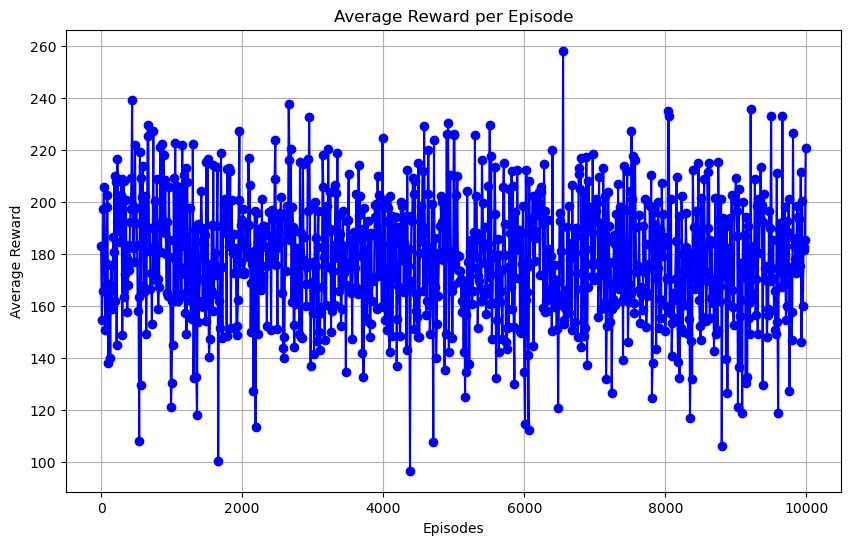

In [15]:
import matplotlib.pyplot as plt

print_freq = 200  
average_rewards = [sum(all_episode_rewards[i:i+print_freq]) / print_freq for i in range(0, len(all_episode_rewards), print_freq)]
episodes = [i for i in range(0, len(all_episode_rewards), print_freq)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, average_rewards, marker='o', linestyle='-', color='b')
plt.title("Average Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats  # Import the stats module from SciPy
print_freq = 10 
average_rewards = [sum(all_episode_rewards[i:i+print_freq]) / print_freq for i in range(0, len(all_episode_rewards), print_freq)]
avg_cost = sum(all_episode_costs[-print_freq:]) / print_freq for i in range(0, len(all_episode_cost), print_freq)]
episodes = [i for i in range(0, len(all_episode_rewards), print_freq)]


# Calculate trend lines
slope_reward, intercept_reward, _, _, _ = stats.linregress(episodes, rewards)
slope_cost, intercept_cost, _, _, _ = stats.linregress(episodes, costs)
line_reward = intercept_reward + slope_reward * episodes
line_cost = intercept_cost + slope_cost * episodes

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot rewards
axs[0].scatter(episodes, rewards, alpha=0.5, label='Reward Data', color='turquoise')
axs[0].plot(episodes, line_reward, 'r', label='Reward Trend')
axs[0].set_title('Average Reward Over Episodes')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Average Reward')
axs[0].set_ylim(190, 170)  # Set y-axis limits for the first subplot
axs[0].legend()

# Plot costs
axs[1].scatter(episodes, costs, alpha=0.5, label='Cost Data', color='blue')
axs[1].plot(episodes, line_cost, 'g', label='Cost Trend')
axs[1].set_title('Average Cost Over Episodes')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Average Cost')
axs[1].set_ylim(430, 460)  # Set y-axis limits for the second subplot
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (4094465391.py, line 6)

In [ ]:
import torch
import torch.nn as nn

# Assuming actor_critic is your trained model instance
torch.save(actor_critic.state_dict(), 'actor_critic_state.pth')

# Assuming the ActorCriticNetwork class is defined as before
actor_critic = ActorCriticNetwork(obs_space_size=153, action_space_size=30)
actor_critic.load_state_dict(torch.load('actor_critic_state.pth'))
actor_critic.eval()  # Set the model to evaluation mode

In [ ]:
torch.save(actor_critic, 'actor_critic_full_model.pth')
actor_critic = torch.load('actor_critic_full_model.pth')
actor_critic.eval()  # Set the model to evaluation mode
